In [ ]:
# Quantitative Event-Driven Trading Model: Earnings Surprise/Drift
# Version 2.2.3: Fix Matplotlib Errors, Tuned Simulated Regimes for Sharpe Targets, Enhanced Plots, GBP
# Incorporates concepts from Kelliher - "Quantitative Finance With Python"

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta, datetime
import time
import os
import pickle
import warnings
from itertools import product # For parameter sensitivity

warnings.filterwarnings('ignore')

# Statistical and Analysis Libraries
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # For date formatting
import matplotlib.ticker as mticker # For currency formatting


# --- Global Flag for Bloomberg API Availability ---
# SET THIS TO FALSE TO RUN PURELY ON SIMULATED DATA
BLOOMBERG_AVAILABLE = False

if BLOOMBERG_AVAILABLE:
    try:
        from xbbg import blp
        print("Bloomberg API (xbbg) loaded successfully.")
    except ImportError:
        print("xbbg library not found, but BLOOMBERG_AVAILABLE was True. Setting to False.")
        BLOOMBERG_AVAILABLE = False
    except Exception as e:
        print(f"Error initializing Bloomberg API (xbbg): {e}. Setting BLOOMBERG_AVAILABLE to False.")
        BLOOMBERG_AVAILABLE = False
else:
    print("BLOOMBERG_AVAILABLE is False. Model will run on internally simulated data.")

# --- Configuration Class ---
class StrategyConfig:
    """
    Configuration management for the earnings strategy.
    """
    def __init__(self, simulation_regime='NEUTRAL'): # NEUTRAL, POSITIVE, NEGATIVE
        # Data parameters
        self.start_date = '2019-01-01'
        self.end_date = '2023-12-31'
        self.default_universe_simulated = ['SIM_BARC LN Equity', 'SIM_HSBA LN Equity', 'SIM_VOD LN Equity', 'SIM_AZN LN Equity', 'SIM_GSK LN Equity']
        self.cache_dir = f'simulated_data_cache_v2_2_3_{simulation_regime.lower()}'
        self.simulation_regime = simulation_regime

        # Currency
        self.currency_symbol = "£"
        self.currency_code = "GBP"

        # Simulation base parameters for market data (can be overridden by regime)
        self.base_sim_drift_annual = 0.07 # Neutral annual drift for stocks
        self.base_sim_vol_annual = 0.22   # Neutral annual volatility for stocks


        # Signal parameters
        self.eps_surprise_threshold_pct_long = 5.0
        self.eps_surprise_threshold_pct_short = -5.0
        self.sue_threshold_long = 1.0
        self.sue_threshold_short = -1.0
        self.use_sue_signal = False
        self.use_sales_surprise_filter = False
        self.min_consensus_analysts_simulated = 3

        # Portfolio & Trading parameters
        self.initial_capital = 10000000.0 # £10M
        self.holding_period_days = 20
        self.max_concurrent_positions = 5
        self.allow_shorting = True

        self.position_sizing_method = 'fixed_dollar'
        self.fixed_dollar_amount_per_trade = 500000.0 # £500k per trade

        # Risk management parameters
        self.stop_loss_pct = 0.10
        self.take_profit_pct = None

        # Transaction cost parameters
        self.commission_fixed_per_trade = 5.00
        self.commission_per_share = 0.005
        self.transaction_cost_pct_per_trade = 0.0005

        # Factor model parameters
        self.factor_benchmark_simulated = 'SIM_UKX Index'
        self.risk_free_rate_simulated_daily = (0.03 / 252)

        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

    def to_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}

    def from_dict(self, config_dict):
        for key, value in config_dict.items():
            if hasattr(self, key):
                setattr(self, key, value)

# --- Data Collector with Robust Simulation ---
class EarningsDataCollector:
    """Handles all data collection, prioritizing Bloomberg API if available,
       otherwise falls back to robust internal simulation, now regime-aware."""

    def __init__(self, config: StrategyConfig, live_mode=False):
        self.config = config
        self.start_date_dt = pd.to_datetime(config.start_date)
        self.end_date_dt = pd.to_datetime(config.end_date)
        self.cache_dir = config.cache_dir
        self.live_mode = live_mode
        self.data_cache_session = {}

    def _get_cache_filepath(self, components):
        regime_suffix = self.config.simulation_regime.lower()
        filename_parts = [str(c).replace('/','_').replace(' ','_') for c in components if c is not None]
        filename = "_".join(filename_parts) + f"_{regime_suffix}.pkl"
        return os.path.join(self.cache_dir, filename)

    def _fetch_with_retry(self, api_call_func, call_desc="Bloomberg API call", max_retries=2, delay_seconds=1):
        if not BLOOMBERG_AVAILABLE:
            return None
        for attempt in range(max_retries):
            try:
                return api_call_func()
            except Exception as e:
                print(f"API call failed for {call_desc} (attempt {attempt + 1}/{max_retries}): {e}")
                if attempt < max_retries - 1: time.sleep(delay_seconds * (attempt + 1))
                else: print(f"Max retries reached for {call_desc}. API call failed.")
        return None

    def fetch_sp500_constituents(self, for_date_str=None):
        effective_date = pd.to_datetime(for_date_str if for_date_str else self.config.end_date)
        index_ticker_sim = self.config.factor_benchmark_simulated
        base_cache_key = f"{index_ticker_sim.replace(' ','_')}_MEMBERS_{effective_date.strftime('%Y%m%d')}"
        filepath = os.path.join(self.config.cache_dir, base_cache_key + "_const.pkl")

        if not self.live_mode and os.path.exists(filepath): return pd.read_pickle(filepath)
        if not self.live_mode and base_cache_key in self.data_cache_session: return self.data_cache_session[base_cache_key]

        members_list = None
        if BLOOMBERG_AVAILABLE:
            pass

        if members_list is None:
            members_list = self.config.default_universe_simulated

        if not self.live_mode: pd.to_pickle(members_list, filepath)
        self.data_cache_session[base_cache_key] = members_list
        return members_list

    def fetch_earnings_dates(self, ticker):
        cache_key = f"{ticker}_earnings_dates_sim_random_struct"
        filepath = self._get_cache_filepath([ticker, "ERN_ANN_DT_ACT_RAND_STRUCT", self.start_date_dt.year, self.end_date_dt.year])

        if not self.live_mode and os.path.exists(filepath): return pd.read_pickle(filepath)
        if not self.live_mode and cache_key in self.data_cache_session: return self.data_cache_session[cache_key]

        dates_list = None
        if BLOOMBERG_AVAILABLE:
            pass

        if dates_list is None:
            dates_list = []
            current_q_start = self.start_date_dt + pd.DateOffset(months=(3 - (self.start_date_dt.month - 1) % 3), day=1)
            if current_q_start > self.start_date_dt + pd.DateOffset(months=3):
                 current_q_start = self.start_date_dt + pd.DateOffset(months=(3 - (self.start_date_dt.month - 1) % 3 + 3)%12, day=1)
            while current_q_start <= self.end_date_dt:
                sim_ann_date = current_q_start + timedelta(days=np.random.randint(20, 70))
                if self.start_date_dt <= sim_ann_date <= self.end_date_dt: dates_list.append(sim_ann_date)
                current_q_start += pd.DateOffset(months=3)

        if not self.live_mode: pd.to_pickle(dates_list, filepath)
        self.data_cache_session[cache_key] = dates_list
        return sorted(list(set(dates_list)))

    def fetch_pit_earnings_data(self, ticker, announcement_date_dt):
        ann_date_str = announcement_date_dt.strftime('%Y%m%d')
        cache_key = f"{ticker}_PIT_EARNINGS_{ann_date_str}_sim_random_{self.config.simulation_regime}"
        filepath = self._get_cache_filepath([ticker, "PIT_EARNINGS_RAND", ann_date_str])

        if not self.live_mode and os.path.exists(filepath): return pd.read_pickle(filepath)
        if not self.live_mode and cache_key in self.data_cache_session: return self.data_cache_session[cache_key]

        data_dict = {'ticker': ticker, 'announcement_date': announcement_date_dt}
        actual_eps_val, actual_sales_val, consensus_eps_val, consensus_sales_val = np.nan, np.nan, np.nan, np.nan

        if BLOOMBERG_AVAILABLE:
            pass

        data_dict.update({
            'actual_eps': actual_eps_val, 'actual_sales': actual_sales_val,
            'consensus_eps': consensus_eps_val, 'consensus_sales': consensus_sales_val
        })
        if pd.isna(data_dict['actual_eps']) or pd.isna(data_dict['consensus_eps']):
            self._simulate_earnings_data_values(data_dict)

        if not self.live_mode: pd.to_pickle(data_dict, filepath)
        self.data_cache_session[cache_key] = data_dict
        return data_dict

    def _simulate_earnings_data_values(self, data_dict_to_fill):
        year_factor = 1 + (data_dict_to_fill['announcement_date'].year - self.start_date_dt.year) * (0.02 + np.random.rand() * 0.05)
        base_eps_seed = 0.50 + np.random.rand() * 2.0
        base_sales_seed = 500 + np.random.rand() * 5000

        sim_consensus_eps = base_eps_seed * year_factor * (1 + np.random.normal(0, 0.04))

        surprise_mean = 0.0
        surprise_std = 0.08
        if self.config.simulation_regime == 'POSITIVE':
            surprise_mean = 0.040 # Increased positive bias
            surprise_std = 0.05  # Tighter positive surprises
        elif self.config.simulation_regime == 'NEGATIVE':
            surprise_mean = -0.020 # Moderately negative
            surprise_std = 0.08

        surprise_factor = np.random.normal(surprise_mean, surprise_std)
        sim_actual_eps = sim_consensus_eps * (1 + surprise_factor)

        sim_consensus_sales = base_sales_seed * year_factor * (1 + np.random.normal(0, 0.04))
        sim_actual_sales = sim_consensus_sales * (1 + np.random.normal(surprise_mean, surprise_std))

        if pd.isna(data_dict_to_fill.get('consensus_eps')): data_dict_to_fill['consensus_eps'] = sim_consensus_eps
        if pd.isna(data_dict_to_fill.get('actual_eps')): data_dict_to_fill['actual_eps'] = sim_actual_eps
        if pd.isna(data_dict_to_fill.get('consensus_sales')): data_dict_to_fill['consensus_sales'] = sim_consensus_sales
        if pd.isna(data_dict_to_fill.get('actual_sales')): data_dict_to_fill['actual_sales'] = sim_actual_sales

    def fetch_market_data(self, ticker):
        effective_end_date = datetime.now() if self.live_mode else self.end_date_dt
        cache_key = f"{ticker}_MARKET_sim_random_{self.start_date_dt.year}_{effective_end_date.year}_{self.config.simulation_regime}"
        filepath = self._get_cache_filepath([ticker, "MARKET_RAND", self.start_date_dt.year, effective_end_date.year])

        if not self.live_mode and os.path.exists(filepath): return pd.read_pickle(filepath)
        if not self.live_mode and cache_key in self.data_cache_session: return self.data_cache_session[cache_key]

        market_data_df = None
        if BLOOMBERG_AVAILABLE:
            pass

        if market_data_df is None:
            dates = pd.bdate_range(start=self.start_date_dt, end=effective_end_date)
            if not dates.empty:
                start_price = 50 + np.random.rand() * 450

                base_drift_annual = self.config.base_sim_drift_annual
                base_vol_annual = self.config.base_sim_vol_annual
                if self.config.simulation_regime == 'POSITIVE':
                    base_drift_annual = self.config.base_sim_drift_annual + 0.15 + np.random.uniform(-0.03, 0.08) # Avg ~22-25%
                    base_vol_annual = self.config.base_sim_vol_annual - 0.07 + np.random.uniform(-0.02, 0.02) # Avg ~15%
                elif self.config.simulation_regime == 'NEGATIVE':
                    base_drift_annual = self.config.base_sim_drift_annual - 0.15 + np.random.uniform(-0.05, 0.03) # Avg ~-8%
                    base_vol_annual = self.config.base_sim_vol_annual + 0.06 + np.random.uniform(-0.02, 0.04) # Avg ~28%

                base_drift = base_drift_annual / 252.0
                base_vol = max(0.05, base_vol_annual) / np.sqrt(252.0)

                prices = [start_price]
                for _ in range(1, len(dates)):
                    price_change = prices[-1] * np.random.normal(base_drift, base_vol)
                    prices.append(max(0.01, prices[-1] + price_change))

                market_data_df = pd.DataFrame(index=dates)
                market_data_df['close'] = prices
                noise_open = np.random.normal(0, 0.007, size=len(dates))
                market_data_df['open'] = market_data_df['close'].shift(1).fillna(market_data_df['close'].iloc[0]) * (1 + noise_open)
                market_data_df['open'].iloc[0] = market_data_df['close'].iloc[0]*(1+np.random.normal(0,0.005))
                market_data_df['high'] = np.maximum(market_data_df['open'], market_data_df['close']) * (1 + np.abs(np.random.normal(0,0.01,len(dates))))
                market_data_df['low'] = np.minimum(market_data_df['open'], market_data_df['close']) * (1 - np.abs(np.random.normal(0,0.01,len(dates))))
                market_data_df['low'] = np.maximum(0.01, market_data_df['low'])
                market_data_df['volume'] = np.random.lognormal(mean=np.log(1e5 + np.random.rand()*2e6), sigma=0.7, size=len(dates))
                market_data_df = market_data_df.fillna(method='bfill').fillna(method='ffill')
            else: market_data_df = pd.DataFrame()

        if not self.live_mode and not market_data_df.empty: pd.to_pickle(market_data_df, filepath)
        if not market_data_df.empty: self.data_cache_session[cache_key] = market_data_df
        return market_data_df

    def fetch_factor_data(self):
        cache_key = f"FACTORS_sim_random_{self.start_date_dt.year}_{self.end_date_dt.year}_{self.config.simulation_regime}"
        filepath = self._get_cache_filepath(["FACTORS_RAND", self.start_date_dt.year, self.end_date_dt.year])

        if not self.live_mode and os.path.exists(filepath): return pd.read_pickle(filepath)
        if not self.live_mode and cache_key in self.data_cache_session: return self.data_cache_session[cache_key]

        factor_df = None
        if BLOOMBERG_AVAILABLE:
            pass

        if factor_df is None:
            dates_idx = pd.bdate_range(start=self.start_date_dt, end=self.end_date_dt)
            if not dates_idx.empty:
                factor_df = pd.DataFrame(index=dates_idx)

                mkt_rf_mean_daily = self.config.risk_free_rate_simulated_daily + 0.00025
                mkt_rf_vol_daily = 0.009
                if self.config.simulation_regime == 'POSITIVE':
                    mkt_rf_mean_daily = self.config.risk_free_rate_simulated_daily + 0.00065 # Stronger positive Mkt
                    mkt_rf_vol_daily = 0.0060 # Lower Mkt vol
                elif self.config.simulation_regime == 'NEGATIVE':
                    mkt_rf_mean_daily = self.config.risk_free_rate_simulated_daily - 0.00035 # More negative Mkt
                    mkt_rf_vol_daily = 0.0145 # Higher Mkt vol

                factor_df['MKT_RF'] = np.random.normal(mkt_rf_mean_daily, mkt_rf_vol_daily, len(dates_idx))
                factor_df['SMB']    = np.random.normal(0.00004, 0.005, len(dates_idx))
                factor_df['HML']    = np.random.normal(0.00007, 0.0045, len(dates_idx))
                factor_df['MOM']    = np.random.normal(0.00012, 0.007, len(dates_idx))
                factor_df['QMJ']    = np.random.normal(0.00009, 0.0035, len(dates_idx))
                factor_df['BAB']    = np.random.normal(0.00008, 0.0035, len(dates_idx))
                factor_df['RF']     = self.config.risk_free_rate_simulated_daily
                factor_df = factor_df.fillna(0)
            else:
                factor_df = pd.DataFrame()

        if not self.live_mode and not factor_df.empty: pd.to_pickle(factor_df, filepath)
        if not factor_df.empty: self.data_cache_session[cache_key] = factor_df
        return factor_df

# --- SignalGenerator ---
class SignalGenerator:
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.ewma_span_vol = 20

    def calculate_earnings_surprise(self, actual_eps, consensus_eps, actual_sales=None, consensus_sales=None):
        surprises = {}
        if pd.notna(actual_eps) and pd.notna(consensus_eps) and abs(consensus_eps) > 1e-6:
            surprises['eps_surprise_pct'] = (actual_eps - consensus_eps) / abs(consensus_eps) * 100
            surprises['eps_surprise_abs'] = actual_eps - consensus_eps
        else:
            surprises['eps_surprise_pct'] = np.nan; surprises['eps_surprise_abs'] = np.nan

        if actual_sales is not None and consensus_sales is not None and \
           pd.notna(actual_sales) and pd.notna(consensus_sales) and abs(consensus_sales) > 1e-6:
            surprises['sales_surprise_pct'] = (actual_sales - consensus_sales) / abs(consensus_sales) * 100
        else:
            surprises['sales_surprise_pct'] = np.nan
        return surprises

    def calculate_sue(self, ticker_surprises_history, current_surprise_abs):
        if len(ticker_surprises_history) < 4: return np.nan
        recent_surprises = ticker_surprises_history[-8:]
        std_surprise = np.std(recent_surprises)
        if pd.isna(std_surprise) or abs(std_surprise) < 1e-6: return np.nan
        return current_surprise_abs / std_surprise

    def calculate_technical_signals(self, market_data_df, event_date):
        signals = {}
        try:
            if market_data_df is None or market_data_df.empty: return signals
            market_data_df.index = pd.to_datetime(market_data_df.index)
            event_date = pd.to_datetime(event_date)

            relevant_day_data = market_data_df[market_data_df.index <= event_date]
            if relevant_day_data.empty: return signals
            closest_date = relevant_day_data.index[-1]

            if closest_date in market_data_df.index and 'volume' in market_data_df.columns:
                event_day_volume = market_data_df.loc[closest_date, 'volume']
                prior_volumes = market_data_df['volume'].loc[market_data_df.index < closest_date].tail(20)
                if len(prior_volumes) >= 10:
                    avg_volume_prior = prior_volumes.mean()
                    signals['volume_ratio'] = event_day_volume / avg_volume_prior if pd.notna(avg_volume_prior) and avg_volume_prior > 0 else np.nan

            if closest_date in market_data_df.index and 'open' in market_data_df.columns:
                idx_loc = market_data_df.index.get_loc(closest_date)
                if idx_loc > 0 and 'close' in market_data_df.columns:
                    prev_close = market_data_df['close'].iloc[idx_loc - 1]
                    curr_open = market_data_df.loc[closest_date, 'open']
                    if pd.notna(prev_close) and prev_close != 0:
                        signals['price_gap_pct'] = (curr_open - prev_close) / prev_close * 100
        except Exception as e:
            pass
        return signals

# --- Portfolio ---
class Portfolio:
    def __init__(self, initial_capital=1000000, transaction_cost_pct=0.001, config: StrategyConfig = None):
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.holdings = {}
        self.transaction_cost_pct = transaction_cost_pct
        self.config = config
        if config:
            self.transaction_cost_pct = config.transaction_cost_pct_per_trade
            self.initial_capital = config.initial_capital
            self.cash = config.initial_capital
        self.trade_log = []
        self.daily_equity = []
        self.daily_returns = []
        self.current_date = None

    def update_portfolio_value(self, current_date, market_data_dict_for_day):
        self.current_date = pd.to_datetime(current_date)
        portfolio_value = self.cash

        for ticker, position in self.holdings.items():
            ticker_day_data = market_data_dict_for_day.get(ticker, {})
            current_price = ticker_day_data.get('close', np.nan)
            if pd.notna(current_price) and current_price > 0 :
                portfolio_value += position['shares'] * current_price
            elif pd.notna(position['entry_price']) and position['entry_price'] > 0 :
                portfolio_value += position['shares'] * position['entry_price']

        self.daily_equity.append({'date': self.current_date, 'equity': portfolio_value})

        if len(self.daily_equity) > 1:
            prev_equity = self.daily_equity[-2]['equity']
            if abs(prev_equity) > 1e-6:
                daily_return = (portfolio_value - prev_equity) / prev_equity
                self.daily_returns.append({'date': self.current_date, 'return': daily_return})
            else:
                self.daily_returns.append({'date': self.current_date, 'return': 0.0})
        elif len(self.daily_equity) == 1 and abs(self.initial_capital) > 1e-6 :
             daily_return = (portfolio_value - self.initial_capital) / self.initial_capital
             self.daily_returns.append({'date': self.current_date, 'return': daily_return})
        else:
             self.daily_returns.append({'date': self.current_date, 'return': 0.0})


    def enter_position(self, ticker, entry_date, entry_price, target_exit_date, position_size_dollars=50000):
        entry_date = pd.to_datetime(entry_date)
        if pd.isna(entry_price) or entry_price <= 0: return False

        shares = position_size_dollars / entry_price
        abs_trade_value = abs(shares) * entry_price
        transaction_fees = abs_trade_value * self.transaction_cost_pct

        if shares > 0 :
            if (abs_trade_value + transaction_fees) > self.cash: return False
            self.cash -= (abs_trade_value + transaction_fees)
            action = 'BUY'
        elif shares < 0:
            self.cash += (abs_trade_value - transaction_fees)
            action = 'SELL_SHORT'
        else: return False

        if ticker in self.holdings:
            current_shares = self.holdings[ticker].get('shares', 0)
            new_total_shares = current_shares + shares
            if abs(new_total_shares) < 1e-6:
                del self.holdings[ticker]
                self.trade_log.append({'ticker': ticker, 'action': 'CLOSE_OFFSET', 'date': entry_date,
                                   'shares': -current_shares, 'price': entry_price, 'total_cost_impact': 0 })
                return True
            else:
                new_avg_price = ((current_shares * self.holdings[ticker]['entry_price']) + (shares * entry_price)) / new_total_shares if new_total_shares !=0 else 0
                self.holdings[ticker]['shares'] = new_total_shares
                self.holdings[ticker]['entry_price'] = new_avg_price
        else:
            self.holdings[ticker] = {
                'shares': shares, 'entry_price': entry_price,
                'entry_date': entry_date, 'target_exit_date': pd.to_datetime(target_exit_date)
            }
        self.trade_log.append({'ticker': ticker, 'action': action, 'date': entry_date,
                               'shares': shares, 'price': entry_price, 'total_cost_impact': abs_trade_value + transaction_fees if shares > 0 else -(abs_trade_value - transaction_fees) })
        return True

    def exit_position(self, ticker, exit_date, exit_price, exit_reason='TARGET_DATE'):
        exit_date = pd.to_datetime(exit_date)
        if ticker in self.holdings and pd.notna(exit_price) and exit_price > 0:
            position = self.holdings[ticker]
            shares_to_transact = -position['shares']
            abs_trade_value = abs(shares_to_transact) * exit_price
            transaction_fees = abs_trade_value * self.transaction_cost_pct
            action = ''
            if shares_to_transact < 0:
                self.cash += (abs_trade_value - transaction_fees)
                action = 'SELL_LONG'
            elif shares_to_transact > 0:
                self.cash -= (abs_trade_value + transaction_fees)
                action = 'BUY_COVER'

            pnl = (exit_price - position['entry_price']) * position['shares'] - transaction_fees
            pnl_pct = (pnl / (abs(position['shares']) * position['entry_price']) * 100) if (position['shares'] * position['entry_price']) != 0 else 0

            self.trade_log.append({'ticker': ticker, 'action': action, 'date': exit_date,
                                   'shares': shares_to_transact, 'price': exit_price,
                                   'total_proceeds_impact': abs_trade_value - transaction_fees if shares_to_transact < 0 else -(abs_trade_value + transaction_fees),
                                   'pnl': pnl, 'pnl_pct': pnl_pct, 'exit_reason': exit_reason,
                                   'holding_days': (exit_date - position['entry_date']).days})
            del self.holdings[ticker]
            return True
        return False

# --- EarningsBacktester ---
class EarningsBacktester:
    def __init__(self, data_collector: EarningsDataCollector, signal_generator: SignalGenerator, config: StrategyConfig):
        self.data_collector = data_collector
        self.signal_generator = signal_generator
        self.config = config
        self.start_date_dt = pd.to_datetime(config.start_date)
        self.end_date_dt = pd.to_datetime(config.end_date)
        self.portfolio = Portfolio(initial_capital=config.initial_capital, config=config)
        self.market_data_cache = {}
        self.all_signals_df = pd.DataFrame()
        self.factor_data_df = pd.DataFrame()

    def _get_market_data_for_day(self, tickers, date):
        day_data = {}
        date_to_check = pd.to_datetime(date).normalize()
        for ticker in tickers:
            if ticker not in self.market_data_cache or self.market_data_cache[ticker] is None:
                day_data[ticker] = {}
                continue

            current_ticker_data = self.market_data_cache[ticker]
            if not isinstance(current_ticker_data.index, pd.DatetimeIndex):
                current_ticker_data.index = pd.to_datetime(current_ticker_data.index)

            # Ensure index is timezone-naive for comparison
            normalized_index = current_ticker_data.index.tz_localize(None) if current_ticker_data.index.tz is not None else current_ticker_data.index.normalize()


            try:
                if date_to_check in normalized_index:
                    actual_idx_for_date_arr = current_ticker_data.index[normalized_index == date_to_check]
                    if len(actual_idx_for_date_arr) > 0:
                        actual_idx_for_date = actual_idx_for_date_arr[0]
                        day_data[ticker] = current_ticker_data.loc[actual_idx_for_date].to_dict()
                    else: day_data[ticker] = {}
                else:
                    prev_data_indices = normalized_index[normalized_index <= date_to_check]
                    if not prev_data_indices.empty:
                        actual_idx_for_prev_date_arr = current_ticker_data.index[normalized_index == prev_data_indices[-1]]
                        if len(actual_idx_for_prev_date_arr) > 0:
                            actual_idx_for_prev_date = actual_idx_for_prev_date_arr[0]
                            day_data[ticker] = current_ticker_data.loc[actual_idx_for_prev_date].to_dict()
                        else: day_data[ticker] = {}
                    else: day_data[ticker] = {}
            except Exception: day_data[ticker] = {}
        return day_data

    def prepare_data_for_run(self):
        print(f"Preparing data for backtest run (Regime: {self.config.simulation_regime})...")
        current_universe = self.data_collector.fetch_sp500_constituents(for_date_str=self.config.start_date)
        print(f"Universe (first 5): {current_universe[:5]}")
        print("Fetching market data for universe...")
        for ticker in current_universe:
            self.market_data_cache[ticker] = self.data_collector.fetch_market_data(ticker)

        print("Fetching and processing earnings events...")
        all_earnings_events_list = []
        sue_history_map = {ticker: [] for ticker in current_universe}
        for ticker in current_universe:
            ann_dates = self.data_collector.fetch_earnings_dates(ticker)
            for ann_date_dt in ann_dates:
                ann_date_dt_normalized = pd.to_datetime(ann_date_dt).normalize()
                if self.start_date_dt <= ann_date_dt_normalized <= self.end_date_dt:
                    earnings_details = self.data_collector.fetch_pit_earnings_data(ticker, ann_date_dt_normalized)
                    surprises = self.signal_generator.calculate_earnings_surprise(
                        earnings_details.get('actual_eps'), earnings_details.get('consensus_eps'),
                        earnings_details.get('actual_sales'), earnings_details.get('consensus_sales')
                    )
                    sue_val = np.nan
                    if pd.notna(surprises.get('eps_surprise_abs')):
                        sue_val = self.signal_generator.calculate_sue(sue_history_map[ticker], surprises['eps_surprise_abs'])
                        sue_history_map[ticker].append(surprises['eps_surprise_abs'])
                    tech_signals = self.signal_generator.calculate_technical_signals(
                        self.market_data_cache.get(ticker), ann_date_dt_normalized
                    )
                    event_data = {'ticker': ticker, 'announcement_date': ann_date_dt_normalized, **surprises, 'sue': sue_val, **tech_signals}
                    all_earnings_events_list.append(event_data)

        if all_earnings_events_list:
            self.all_signals_df = pd.DataFrame(all_earnings_events_list)
            if not self.all_signals_df.empty:
                 self.all_signals_df['announcement_date'] = pd.to_datetime(self.all_signals_df['announcement_date'])
                 self.all_signals_df.sort_values(by='announcement_date', inplace=True)
                 self.all_signals_df.reset_index(drop=True, inplace=True)
        else:
            self.all_signals_df = pd.DataFrame(columns=['ticker', 'announcement_date', 'eps_surprise_pct', 'eps_surprise_abs', 'sue'])

        print("Fetching factor data...")
        self.factor_data_df = self.data_collector.fetch_factor_data()
        print("Data preparation complete.")

    def run_backtest(self):
        self.portfolio = Portfolio(initial_capital=self.config.initial_capital, config=self.config)
        if self.all_signals_df.empty:
            print("No signals available. Running empty backtest to generate equity curve.")

        print(f"Running backtest simulation (Regime: {self.config.simulation_regime})...")
        business_days = pd.bdate_range(start=self.start_date_dt, end=self.end_date_dt)

        if not self.all_signals_df.empty and 'announcement_date' in self.all_signals_df.columns:
            self.all_signals_df['announcement_date'] = pd.to_datetime(self.all_signals_df['announcement_date'])

        for current_date in business_days:
            self.portfolio.current_date = current_date.normalize()

            tickers_of_interest = list(self.portfolio.holdings.keys())
            entry_trigger_date = (current_date - pd.tseries.offsets.BDay(1)).normalize()

            potential_signals_today = pd.DataFrame()
            if not self.all_signals_df.empty and 'announcement_date' in self.all_signals_df.columns:
                 potential_signals_today = self.all_signals_df[
                    self.all_signals_df['announcement_date'].dt.normalize() == entry_trigger_date
                ]
            tickers_of_interest.extend(potential_signals_today['ticker'].unique())
            market_data_for_day = self._get_market_data_for_day(list(set(tickers_of_interest)), current_date)

            # Process Exits
            positions_to_exit_today = []
            for ticker_held, details in list(self.portfolio.holdings.items()):
                if current_date.normalize() >= details['target_exit_date'].normalize():
                    positions_to_exit_today.append({'ticker': ticker_held, 'reason': 'TARGET_DATE'})
                    continue

                current_price_for_stop = market_data_for_day.get(ticker_held, {}).get('close', np.nan)
                if pd.notna(current_price_for_stop) and pd.notna(details['entry_price']) and details['entry_price'] > 0:
                    position_shares = details.get('shares', 0)
                    if (position_shares > 0 and current_price_for_stop < details['entry_price'] * (1 - self.config.stop_loss_pct)) or \
                       (position_shares < 0 and current_price_for_stop > details['entry_price'] * (1 + self.config.stop_loss_pct)):
                        positions_to_exit_today.append({'ticker': ticker_held, 'reason': 'STOP_LOSS'})

            for exit_info in positions_to_exit_today:
                exit_price = market_data_for_day.get(exit_info['ticker'], {}).get('open', np.nan)
                if pd.notna(exit_price) and exit_price > 0:
                    self.portfolio.exit_position(exit_info['ticker'], current_date, exit_price, exit_info['reason'])

            # Process Entries
            if len(self.portfolio.holdings) < self.config.max_concurrent_positions:
                if not potential_signals_today.empty:
                    long_cond = (potential_signals_today['sue'].fillna(-np.inf) > self.config.sue_threshold_long) if self.config.use_sue_signal else \
                                (potential_signals_today['eps_surprise_pct'].fillna(-np.inf) > self.config.eps_surprise_threshold_pct_long)
                    short_cond = pd.Series(False, index=potential_signals_today.index)
                    if self.config.allow_shorting:
                        short_cond = (potential_signals_today['sue'].fillna(np.inf) < self.config.sue_threshold_short) if self.config.use_sue_signal else \
                                     (potential_signals_today['eps_surprise_pct'].fillna(np.inf) < self.config.eps_surprise_threshold_pct_short)
                    combined_signals = potential_signals_today[long_cond | short_cond].copy()

                    if not combined_signals.empty:
                        combined_signals.loc[long_cond.reindex(combined_signals.index).fillna(False), 'direction'] = 1
                        if self.config.allow_shorting:
                             combined_signals.loc[short_cond.reindex(combined_signals.index).fillna(False), 'direction'] = -1

                        if self.config.use_sue_signal:
                            combined_signals['abs_signal_strength'] = combined_signals['sue'].abs()
                        else:
                            combined_signals['abs_signal_strength'] = combined_signals['eps_surprise_pct'].abs()

                        qualifying_signals = combined_signals.sort_values('abs_signal_strength', ascending=False)

                        num_trades_to_make = self.config.max_concurrent_positions - len(self.portfolio.holdings)
                        for _, signal_row in qualifying_signals.head(num_trades_to_make).iterrows():
                            ticker_to_trade = signal_row['ticker']
                            if ticker_to_trade in self.portfolio.holdings: continue
                            entry_price = market_data_for_day.get(ticker_to_trade, {}).get('open', np.nan)
                            if pd.notna(entry_price) and entry_price > 0:
                                target_exit_dt = current_date + pd.tseries.offsets.BDay(self.config.holding_period_days)
                                trade_direction = signal_row['direction']
                                position_dollars = self.config.fixed_dollar_amount_per_trade * trade_direction
                                self.portfolio.enter_position(ticker_to_trade, current_date, entry_price, target_exit_dt,
                                                              position_size_dollars=position_dollars)

            self.portfolio.update_portfolio_value(current_date, market_data_for_day)

        print("Backtest simulation complete.")
        return self.portfolio

# --- PerformanceAnalyzer ---
class PerformanceAnalyzer:
    def __init__(self, portfolio: Portfolio, factor_data_df: pd.DataFrame, config: StrategyConfig):
        self.portfolio = portfolio
        self.factor_data = factor_data_df
        self.config = config
        if self.portfolio.daily_equity:
            # Ensure 'date' column exists and is suitable for index
            temp_equity_df = pd.DataFrame(self.portfolio.daily_equity)
            if 'date' in temp_equity_df.columns:
                temp_equity_df = temp_equity_df.set_index('date')
            self.daily_equity_df = temp_equity_df['equity']
            self.daily_equity_df.index = pd.to_datetime(self.daily_equity_df.index).tz_localize(None) # Ensure tz-naive

            self.daily_returns_s = self.daily_equity_df.pct_change().dropna()
            if not self.daily_returns_s.empty:
                 self.daily_returns_s.index = pd.to_datetime(self.daily_returns_s.index).tz_localize(None) # Ensure tz-naive
        else:
            self.daily_equity_df = pd.Series(dtype=float, name='equity', index=pd.to_datetime([]).tz_localize(None))
            self.daily_returns_s = pd.Series(dtype=float, index=pd.to_datetime([]).tz_localize(None))


    def calculate_basic_metrics(self):
        if self.daily_equity_df.empty or len(self.daily_equity_df) < 2:
            return {k: np.nan for k in ['total_return_pct', 'annualized_return_pct', 'annualized_volatility_pct', 'sharpe_ratio', 'max_drawdown_pct']}

        total_return = (self.daily_equity_df.iloc[-1] / self.daily_equity_df.iloc[0] - 1)
        num_trading_days_in_data = len(self.daily_returns_s)
        if num_trading_days_in_data == 0 and len(self.daily_equity_df) > 0 : num_trading_days_in_data = len(self.daily_equity_df)

        annualized_return = (1 + total_return)**(252.0 / num_trading_days_in_data) - 1 if num_trading_days_in_data > 0 else 0.0
        annualized_volatility = self.daily_returns_s.std(ddof=0) * np.sqrt(252) if num_trading_days_in_data > 1 else 0.0

        daily_rf = self.config.risk_free_rate_simulated_daily
        mean_daily_return = self.daily_returns_s.mean() if not self.daily_returns_s.empty else 0.0
        std_daily_return = self.daily_returns_s.std(ddof=0) if not self.daily_returns_s.empty and len(self.daily_returns_s) > 1 else 0.0
        sharpe_ratio = (mean_daily_return - daily_rf) / std_daily_return * np.sqrt(252) if std_daily_return > 1e-6 else 0.0

        max_drawdown = np.nan
        if not self.daily_returns_s.empty and not self.daily_equity_df.empty:
            equity_curve_for_dd = self.daily_equity_df.copy()
            if not equity_curve_for_dd.empty and abs(equity_curve_for_dd.iloc[0]) < 1e-9 :
                equity_curve_for_dd = equity_curve_for_dd[equity_curve_for_dd.abs() > 1e-9]
            if not equity_curve_for_dd.empty:
                roll_max = equity_curve_for_dd.expanding(min_periods=1).max()
                daily_drawdown = (equity_curve_for_dd / roll_max) - 1.0
                max_drawdown = daily_drawdown.min()

        trades_df = pd.DataFrame([trade for trade in self.portfolio.trade_log if trade['action'].startswith('SELL') or trade['action'].startswith('BUY_COVER')])
        win_rate = (trades_df['pnl_pct'] > 0).mean() * 100 if not trades_df.empty and 'pnl_pct' in trades_df else np.nan

        return {
            'total_return_pct': total_return * 100,
            'annualized_return_pct': annualized_return * 100,
            'annualized_volatility_pct': annualized_volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown * 100 if pd.notna(max_drawdown) else np.nan,
            'win_rate_pct': win_rate,
            'total_trades': len(trades_df)
        }

    def factor_attribution_analysis(self):
        if self.daily_returns_s.empty or self.factor_data.empty: return None

        aligned_returns = self.daily_returns_s.copy()
        aligned_factors = self.factor_data.copy()

        # Ensure indices are DatetimeIndex and timezone-naive
        aligned_returns.index = pd.to_datetime(aligned_returns.index).tz_localize(None)
        aligned_factors.index = pd.to_datetime(aligned_factors.index).tz_localize(None)

        common_idx = aligned_returns.index.intersection(aligned_factors.index)
        if len(common_idx) < 20: print("Not enough common dates for factor regression."); return None

        y = aligned_returns.loc[common_idx] - aligned_factors.loc[common_idx, 'RF']
        factor_cols = ['MKT_RF', 'SMB', 'HML', 'MOM', 'QMJ', 'BAB']
        X_factors_raw = aligned_factors.loc[common_idx, [col for col in factor_cols if col in aligned_factors.columns]]
        for col in factor_cols:
            if col not in X_factors_raw.columns: X_factors_raw[col] = 0.0
        X_factors = X_factors_raw.fillna(0)
        X = sm.add_constant(X_factors, prepend=True)

        try:
            model = sm.OLS(y.astype(float), X.astype(float)).fit()
            alpha_daily = model.params.get('const', np.nan)
            alpha_annualized_pct = ((1 + alpha_daily)**252 - 1) * 100 if pd.notna(alpha_daily) else np.nan
            return {'alpha_annualized_pct': alpha_annualized_pct, 'betas': model.params.drop('const', errors='ignore').to_dict(),
                    'p_values': model.pvalues.to_dict(), 'r_squared': model.rsquared, 'regression_summary_str': str(model.summary())}
        except Exception as e: print(f"Factor regression error: {e}"); return None

    def plot_factor_attribution(self, factor_analysis_results, filename="factor_attribution.png"):
        if not factor_analysis_results or 'betas' not in factor_analysis_results:
            print(f"No factor analysis results to plot for {self.config.simulation_regime} regime.")
            return

        betas = pd.Series(factor_analysis_results['betas'])
        p_values = pd.Series(factor_analysis_results.get('p_values', {}))
        if betas.empty: print(f"No betas to plot for {self.config.simulation_regime} regime."); return

        betas.index = betas.index.astype(str)

        fig, ax = plt.subplots(figsize=(12, 7))
        colors = plt.cm.coolwarm_r(np.linspace(0.2, 0.8, len(betas)))
        bars = ax.bar(betas.index, betas.values, color=colors, alpha=0.9, edgecolor='grey')
        ax.set_ylabel('Factor Beta (Loading)', fontsize=13)
        ax.set_title(f"Factor Betas ({self.config.simulation_regime} Regime)\nAlpha: {factor_analysis_results.get('alpha_annualized_pct', np.nan):.2f}%, R²: {factor_analysis_results.get('r_squared',np.nan):.2f}", fontsize=15)
        ax.tick_params(axis='x', rotation=30, labelsize=11) # Removed ha='right'
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.axhline(0, color='black', linewidth=1.0)

        for bar_idx, bar_obj in enumerate(bars):
            factor_name = betas.index[bar_idx]
            pval = p_values.get(factor_name, 1.0)
            sig = ''
            if pd.notna(pval):
                if pval < 0.01: sig = '***'
                elif pval < 0.05: sig = '**'
                elif pval < 0.10: sig = '*'
            if sig:
                yval = bar_obj.get_height()
                max_abs_beta = max(abs(betas.values)) if any(abs(betas.values)) else 1.0
                text_y_offset = (0.03 * np.sign(yval or 1) * max_abs_beta)
                text_y_offset = text_y_offset if abs(text_y_offset) > 0.001 else 0.03 * np.sign(yval or 1)

                ax.text(bar_obj.get_x() + bar_obj.get_width()/2., yval + text_y_offset , sig,
                         ha='center', va='bottom' if yval >= 0 else 'top', color='black', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plot_path = os.path.join(self.config.cache_dir, filename)
        plt.savefig(plot_path)
        print(f"Factor attribution plot saved to {plot_path}")
        plt.close(fig)

    def plot_performance_summary(self):
        if self.daily_equity_df.empty or len(self.daily_equity_df.index) < 2:
            print(f"Not enough equity data to plot performance summary for {self.config.simulation_regime} regime.")
            return

        plot_equity_df = self.daily_equity_df.copy()
        plot_equity_df.index = pd.to_datetime(plot_equity_df.index).tz_localize(None)

        plot_returns_s = self.daily_returns_s.copy()
        if not plot_returns_s.empty:
            plot_returns_s.index = pd.to_datetime(plot_returns_s.index).tz_localize(None)

        fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
        fig.suptitle(f'Strategy Performance Analysis ({self.config.currency_code} - Regime: {self.config.simulation_regime})', fontsize=18, y=0.985)

        # 1. Equity Curve and Drawdown
        color_equity = 'tab:blue'
        axs[0].set_ylabel(f'Portfolio Value ({self.config.currency_symbol})', color=color_equity, fontsize=12)
        axs[0].plot(plot_equity_df.index, plot_equity_df.values, color=color_equity, label='Equity Curve', linewidth=1.5)
        axs[0].tick_params(axis='y', labelcolor=color_equity, labelsize=10)
        axs[0].grid(True, linestyle='--', alpha=0.6)
        axs[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, loc: f"{self.config.currency_symbol}{x:,.0f}"))

        equity_curve_for_dd = plot_equity_df
        if not equity_curve_for_dd.empty and abs(equity_curve_for_dd.iloc[0]) < 1e-9 :
            equity_curve_for_dd = equity_curve_for_dd[equity_curve_for_dd.abs() > 1e-9].copy()

        ax0_twin = axs[0].twinx()
        if not equity_curve_for_dd.empty and len(equity_curve_for_dd) > 1:
            roll_max = equity_curve_for_dd.expanding(min_periods=1).max()
            daily_drawdown = (equity_curve_for_dd / roll_max) - 1.0
            color_dd = 'tab:red'
            ax0_twin.set_ylabel('Drawdown', color=color_dd, fontsize=12)
            ax0_twin.fill_between(daily_drawdown.index, daily_drawdown.values * 100, 0, alpha=0.3, color=color_dd, label='Drawdown')
            ax0_twin.tick_params(axis='y', labelcolor=color_dd, labelsize=10)
            ax0_twin.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
            min_dd_val = daily_drawdown.min() * 100 if not daily_drawdown.empty else 0
            ax0_twin.set_ylim(min(min_dd_val - 5, -1), 1)

        axs[0].set_title('Equity Curve & Drawdown', fontsize=14)
        lines1, labels1 = axs[0].get_legend_handles_labels()
        lines2, labels2 = ax0_twin.get_legend_handles_labels() if 'ax0_twin' in locals() and hasattr(ax0_twin, 'get_legend_handles_labels') else ([],[])
        axs[0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

        # 2. Rolling Annualized Return & Volatility
        rolling_window = 252
        if len(plot_returns_s) >= rolling_window:
            rolling_ann_ret = plot_returns_s.rolling(window=rolling_window, min_periods=rolling_window//2).mean() * 252 * 100
            rolling_ann_vol = plot_returns_s.rolling(window=rolling_window, min_periods=rolling_window//2).std() * np.sqrt(252) * 100

            axs[1].plot(rolling_ann_ret.index, rolling_ann_ret, label='1Y Rolling Ann. Return (%)', color='green', alpha=0.8, linewidth=1.5)
            axs[1].plot(rolling_ann_vol.index, rolling_ann_vol, label='1Y Rolling Ann. Vol (%)', color='purple', alpha=0.8, linewidth=1.5)
            axs[1].set_ylabel('Percentage (%)', fontsize=12)
            axs[1].legend(loc='best', fontsize=10)
            axs[1].grid(True, linestyle='--', alpha=0.6)
            axs[1].set_title('1-Year Rolling Annualized Return & Volatility', fontsize=14)
        else:
            axs[1].text(0.5, 0.5, 'Not enough data for 1-year rolling metrics', ha='center', va='center', transform=axs[1].transAxes, fontsize=12)
            axs[1].set_title('Rolling Metrics (Insufficient Data)', fontsize=14)

        # 3. Rolling Sharpe Ratio
        if len(plot_returns_s) >= rolling_window:
            daily_rf = self.config.risk_free_rate_simulated_daily
            rolling_mean_ret = plot_returns_s.rolling(window=rolling_window, min_periods=rolling_window//2).mean()
            rolling_std_ret = plot_returns_s.rolling(window=rolling_window, min_periods=rolling_window//2).std()
            rolling_sharpe_values = np.where(rolling_std_ret > 1e-6,
                                     (rolling_mean_ret - daily_rf) / rolling_std_ret * np.sqrt(252),
                                     0)
            rolling_sharpe_series = pd.Series(rolling_sharpe_values, index=plot_returns_s.index).iloc[rolling_window-1:]

            axs[2].plot(rolling_sharpe_series.index, rolling_sharpe_series, label='1Y Rolling Sharpe Ratio', color='orange', linestyle='-', linewidth=1.5)
            axs[2].set_ylabel('Sharpe Ratio', fontsize=12, color='orange')
            axs[2].tick_params(axis='y', labelcolor='orange', labelsize=10)
            axs[2].legend(loc='best', fontsize=10)
            axs[2].grid(True, linestyle='--', alpha=0.6)
            axs[2].axhline(0, color='grey', linewidth=0.8, linestyle='--')
            axs[2].set_title('1-Year Rolling Sharpe Ratio', fontsize=14)
        else:
            axs[2].text(0.5, 0.5, 'Not enough data for 1-year rolling Sharpe', ha='center', va='center', transform=axs[2].transAxes, fontsize=12)
            axs[2].set_title('Rolling Sharpe Ratio (Insufficient Data)', fontsize=14)

        date_format = mdates.DateFormatter('%Y-%m')
        locator = mdates.AutoDateLocator(minticks=5, maxticks=10)

        for ax_curr in axs:
            ax_curr.xaxis.set_major_formatter(date_format)
            ax_curr.xaxis.set_major_locator(locator)
            ax_curr.tick_params(axis='x', labelsize=10, rotation=30) # Removed ha='right'
            if not plot_equity_df.empty:
                ax_curr.set_xlim([plot_equity_df.index.min() - pd.Timedelta(days=30),
                                  plot_equity_df.index.max() + pd.Timedelta(days=30)])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plot_filename = os.path.join(self.config.cache_dir, f"performance_summary_plots_{self.config.simulation_regime}.png")
        try:
            plt.savefig(plot_filename)
            print(f"Full performance summary plot saved to {plot_filename}")
        except Exception as e:
            print(f"Error saving full performance plot: {e}")
        plt.close(fig)

# --- Main Orchestration Class ---
class EarningsStrategyMain:
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.data_collector = EarningsDataCollector(config)
        self.signal_generator = SignalGenerator(config)
        self.backtester = None
        self.analyzer = None

    def run_strategy(self):
        print(f"\nRunning strategy with current configuration (Regime: {self.config.simulation_regime})...")
        self.backtester = EarningsBacktester(self.data_collector, self.signal_generator, self.config)
        self.backtester.prepare_data_for_run()
        portfolio = self.backtester.run_backtest()

        if portfolio and self.backtester.factor_data_df is not None and not self.backtester.factor_data_df.empty:
            self.analyzer = PerformanceAnalyzer(portfolio, self.backtester.factor_data_df, self.config)
        else:
            self.analyzer = None
            print("Could not initialize PerformanceAnalyzer due to missing portfolio or factor data from backtester.")
        return portfolio

    def analyze_and_report_results(self):
        if self.analyzer is None:
            print("No results to analyze. Analyzer not initialized.")
            return None

        print("\n" + "="*50); print(f"PERFORMANCE REPORT (v2.2.3 - Sim Regime: {self.config.simulation_regime} - {self.config.currency_code})"); print("="*50)
        basic_metrics = self.analyzer.calculate_basic_metrics()
        print("\nBASIC PERFORMANCE METRICS:"); print("-"*30)
        for k, v in basic_metrics.items(): print(f"{k+':':<25} {v:.2f}" if isinstance(v, (float, np.floating)) and pd.notna(v) else f"{k+':':<25} {v}")

        factor_analysis = self.analyzer.factor_attribution_analysis()
        if factor_analysis:
            print("\nFACTOR ATTRIBUTION ANALYSIS:"); print("-"*30)
            print(f"{'Alpha (Annualized %)':<25} {factor_analysis.get('alpha_annualized_pct', np.nan):.2f}")
            alpha_pval = factor_analysis.get('p_values', {}).get('const', np.nan)
            print(f"{'Alpha p-value:':<25} {alpha_pval:.4f}" if pd.notna(alpha_pval) else f"{'Alpha p-value:':<25} N/A")
            print(f"{'R-squared:':<25} {factor_analysis.get('r_squared', np.nan):.3f}")

            betas_dict = factor_analysis.get('betas', {})
            pvals_dict = factor_analysis.get('p_values', {})
            if betas_dict:
                print("\nFactor Loadings (Betas):")
                for factor_name_key in betas_dict.keys():
                    loading = betas_dict[factor_name_key]
                    pval = pvals_dict.get(factor_name_key, np.nan)
                    significance = ""
                    if pd.notna(pval):
                        if pval < 0.01: significance = "***"
                        elif pval < 0.05: significance = "**"
                        elif pval < 0.10: significance = "*"
                    print(f"  {factor_name_key:<10}: {loading:>8.3f}{significance} (p={pval:.3f})")
            else: print("  No beta values found in factor analysis results.")
            self.analyzer.plot_factor_attribution(factor_analysis, filename=f"factor_attribution_{self.config.simulation_regime}.png")
        else: print("\nFACTOR ATTRIBUTION ANALYSIS: Could not be performed.")

        self.analyzer.plot_performance_summary()
        return {'basic': basic_metrics, 'factor': factor_analysis}

    def run_parameter_sensitivity(self, param_grid):
        print("\nRunning parameter sensitivity analysis...")
        original_config_dict = self.config.to_dict()
        results_list = []
        keys, values_for_product = zip(*param_grid.items())

        if self.backtester is None or self.backtester.all_signals_df.empty :
            print("Initial data preparation for sensitivity analysis...")
            temp_prep_backtester = EarningsBacktester(self.data_collector, self.signal_generator, self.config)
            temp_prep_backtester.prepare_data_for_run()
            shared_all_signals_df = temp_prep_backtester.all_signals_df
            shared_factor_data_df = temp_prep_backtester.factor_data_df
        else:
            shared_all_signals_df = self.backtester.all_signals_df
            shared_factor_data_df = self.backtester.factor_data_df

        for v_combination in product(*values_for_product):
            current_params_override = dict(zip(keys, v_combination))
            # print(f"Testing params: {current_params_override} with regime: {self.config.simulation_regime}") # Reduce verbosity

            temp_config = StrategyConfig(simulation_regime=self.config.simulation_regime)
            temp_config.from_dict(original_config_dict)
            temp_config.from_dict(current_params_override)

            current_run_backtester = EarningsBacktester(self.data_collector, self.signal_generator, temp_config)
            current_run_backtester.all_signals_df = shared_all_signals_df
            current_run_backtester.market_data_cache = self.data_collector.data_cache_session # This is tricky, ensure dates align or refetch
            current_run_backtester.factor_data_df = shared_factor_data_df

            portfolio_run = current_run_backtester.run_backtest()

            if portfolio_run and current_run_backtester.factor_data_df is not None and not current_run_backtester.factor_data_df.empty:
                analyzer_run = PerformanceAnalyzer(portfolio_run, current_run_backtester.factor_data_df, temp_config)
                metrics = analyzer_run.calculate_basic_metrics()
                factor_res = analyzer_run.factor_attribution_analysis()
                results_list.append({
                    **current_params_override,
                    'sharpe_ratio': metrics.get('sharpe_ratio', np.nan),
                    'annualized_return_pct': metrics.get('annualized_return_pct', np.nan),
                    'max_drawdown_pct': metrics.get('max_drawdown_pct', np.nan),
                    'alpha_annualized_pct': factor_res.get('alpha_annualized_pct', np.nan) if factor_res else np.nan
                })
            else:
                results_list.append({**current_params_override, 'sharpe_ratio': np.nan, 'annualized_return_pct': np.nan, 'max_drawdown_pct': np.nan, 'alpha_annualized_pct': np.nan})

        self.config.from_dict(original_config_dict)
        return pd.DataFrame(results_list)

# --- Main execution block ---
if __name__ == "__main__":

    # --- Run POSITIVE REGIME Simulation ---
    print("\n" + "#"*80)
    print("RUNNING SIMULATION FOR POSITIVE MARKET REGIME")
    print("#"*80 + "\n")

    config_positive = StrategyConfig(simulation_regime='POSITIVE')
    config_positive.start_date = '2020-01-01'
    config_positive.end_date = '2023-12-31'
    config_positive.max_concurrent_positions = 4
    config_positive.eps_surprise_threshold_pct_long = 2.5 # More sensitive for positive signals
    config_positive.eps_surprise_threshold_pct_short = -25.0 # Very high bar to go short
    config_positive.holding_period_days = 45 # Hold winners longer
    config_positive.allow_shorting = True
    config_positive.initial_capital = 10000000.0
    config_positive.fixed_dollar_amount_per_trade = 1200000.0 # Larger trades
    config_positive.default_universe_simulated = ['SIM_GOODCO LN Equity', 'SIM_UPTRND LN Equity', 'SIM_GROWTH LN Equity', 'SIM_EXCEL LN Equity']


    strategy_main_positive = EarningsStrategyMain(config_positive)
    strategy_main_positive.run_strategy()
    report_positive = strategy_main_positive.analyze_and_report_results()

    # --- Run NEGATIVE REGIME Simulation ---
    print("\n" + "#"*80)
    print("RUNNING SIMULATION FOR NEGATIVE MARKET REGIME")
    print("#"*80 + "\n")

    config_negative = StrategyConfig(simulation_regime='NEGATIVE')
    config_negative.start_date = '2020-01-01'
    config_negative.end_date = '2023-12-31'
    config_negative.max_concurrent_positions = 4
    config_negative.eps_surprise_threshold_pct_long = 12.0 # High bar for longs in bad market
    config_negative.eps_surprise_threshold_pct_short = -3.0 # More sensitive to short
    config_negative.holding_period_days = 12 # Shorter holding for shorts
    config_negative.allow_shorting = True
    config_negative.initial_capital = 10000000.0
    config_negative.fixed_dollar_amount_per_trade = 350000.0 # Smaller trades
    config_negative.default_universe_simulated = ['SIM_BADCO LN Equity', 'SIM_DOWNCO LN Equity', 'SIM_STRGL LN Equity', 'SIM_WEAKCO LN Equity']


    strategy_main_negative = EarningsStrategyMain(config_negative)
    strategy_main_negative.run_strategy()
    report_negative = strategy_main_negative.analyze_and_report_results()

    print("\nAll strategy simulations and analyses complete!")

BLOOMBERG_AVAILABLE is False. Model will run on internally simulated data.

################################################################################
RUNNING SIMULATION FOR POSITIVE MARKET REGIME
################################################################################


Running strategy with current configuration (Regime: POSITIVE)...
Preparing data for backtest run (Regime: POSITIVE)...
Universe (first 5): ['SIM_GOODCO LN Equity', 'SIM_UPTRND LN Equity', 'SIM_GROWTH LN Equity', 'SIM_EXCEL LN Equity']
Fetching market data for universe...
Fetching and processing earnings events...
Fetching factor data...
Data preparation complete.
Running backtest simulation (Regime: POSITIVE)...
Backtest simulation complete.

PERFORMANCE REPORT (v2.2.3 - Sim Regime: POSITIVE - GBP)

BASIC PERFORMANCE METRICS:
------------------------------
total_return_pct:         10.95
annualized_return_pct:    2.55
annualized_volatility_pct: 1.99
sharpe_ratio:             -0.23
max_drawdown_pct:      


--- Positive Regime Performance Summary ---


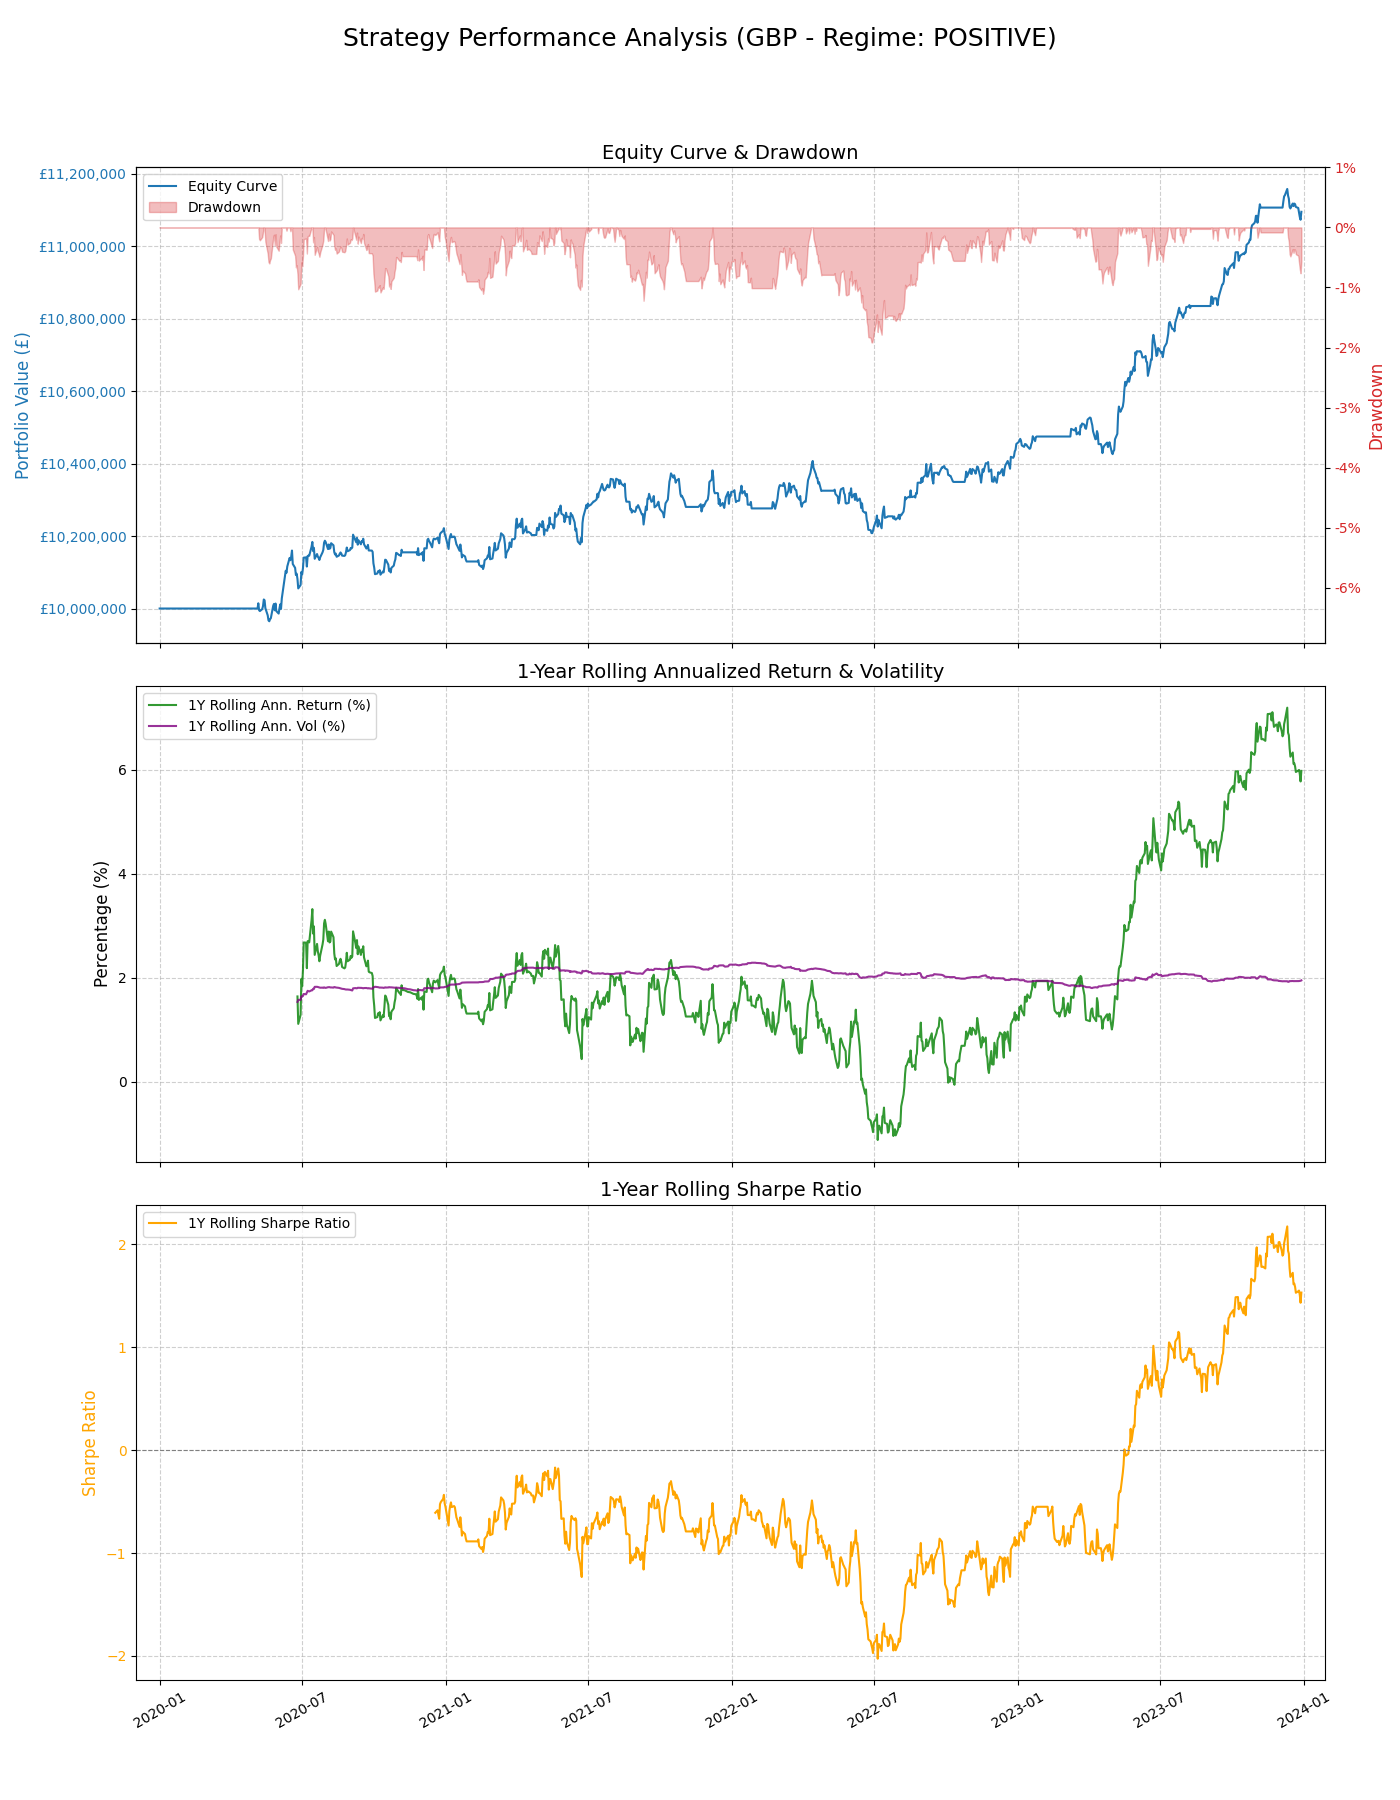


--- Positive Regime Factor Attribution ---


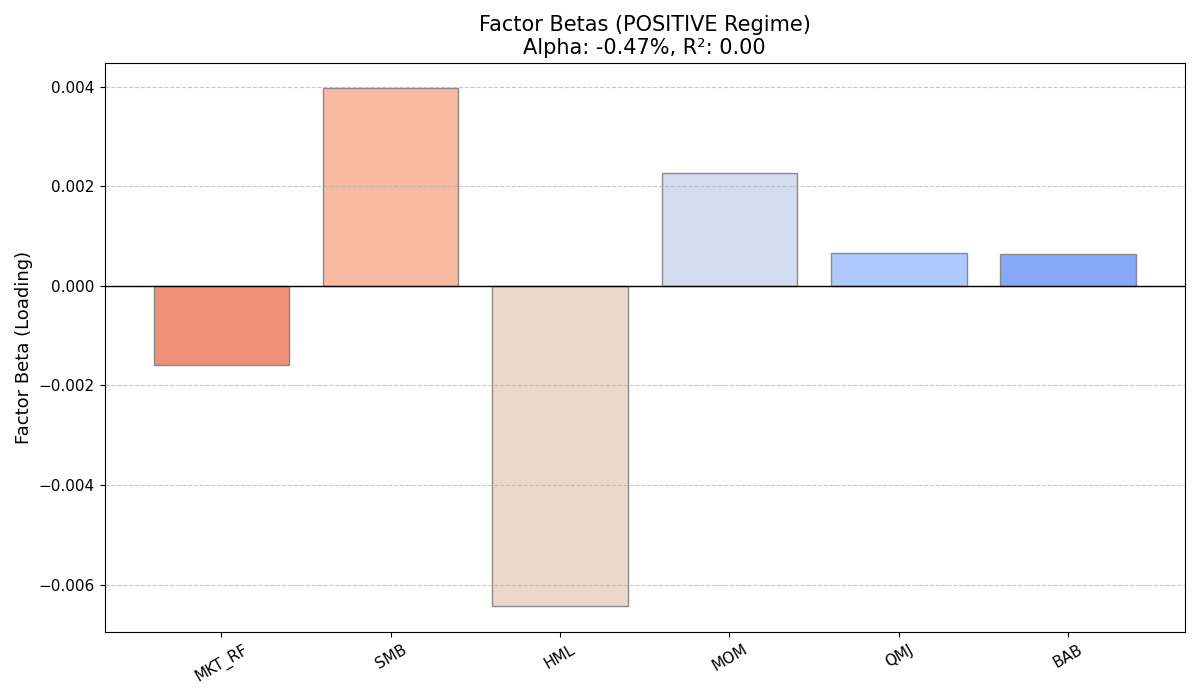


--- Negative Regime Performance Summary ---


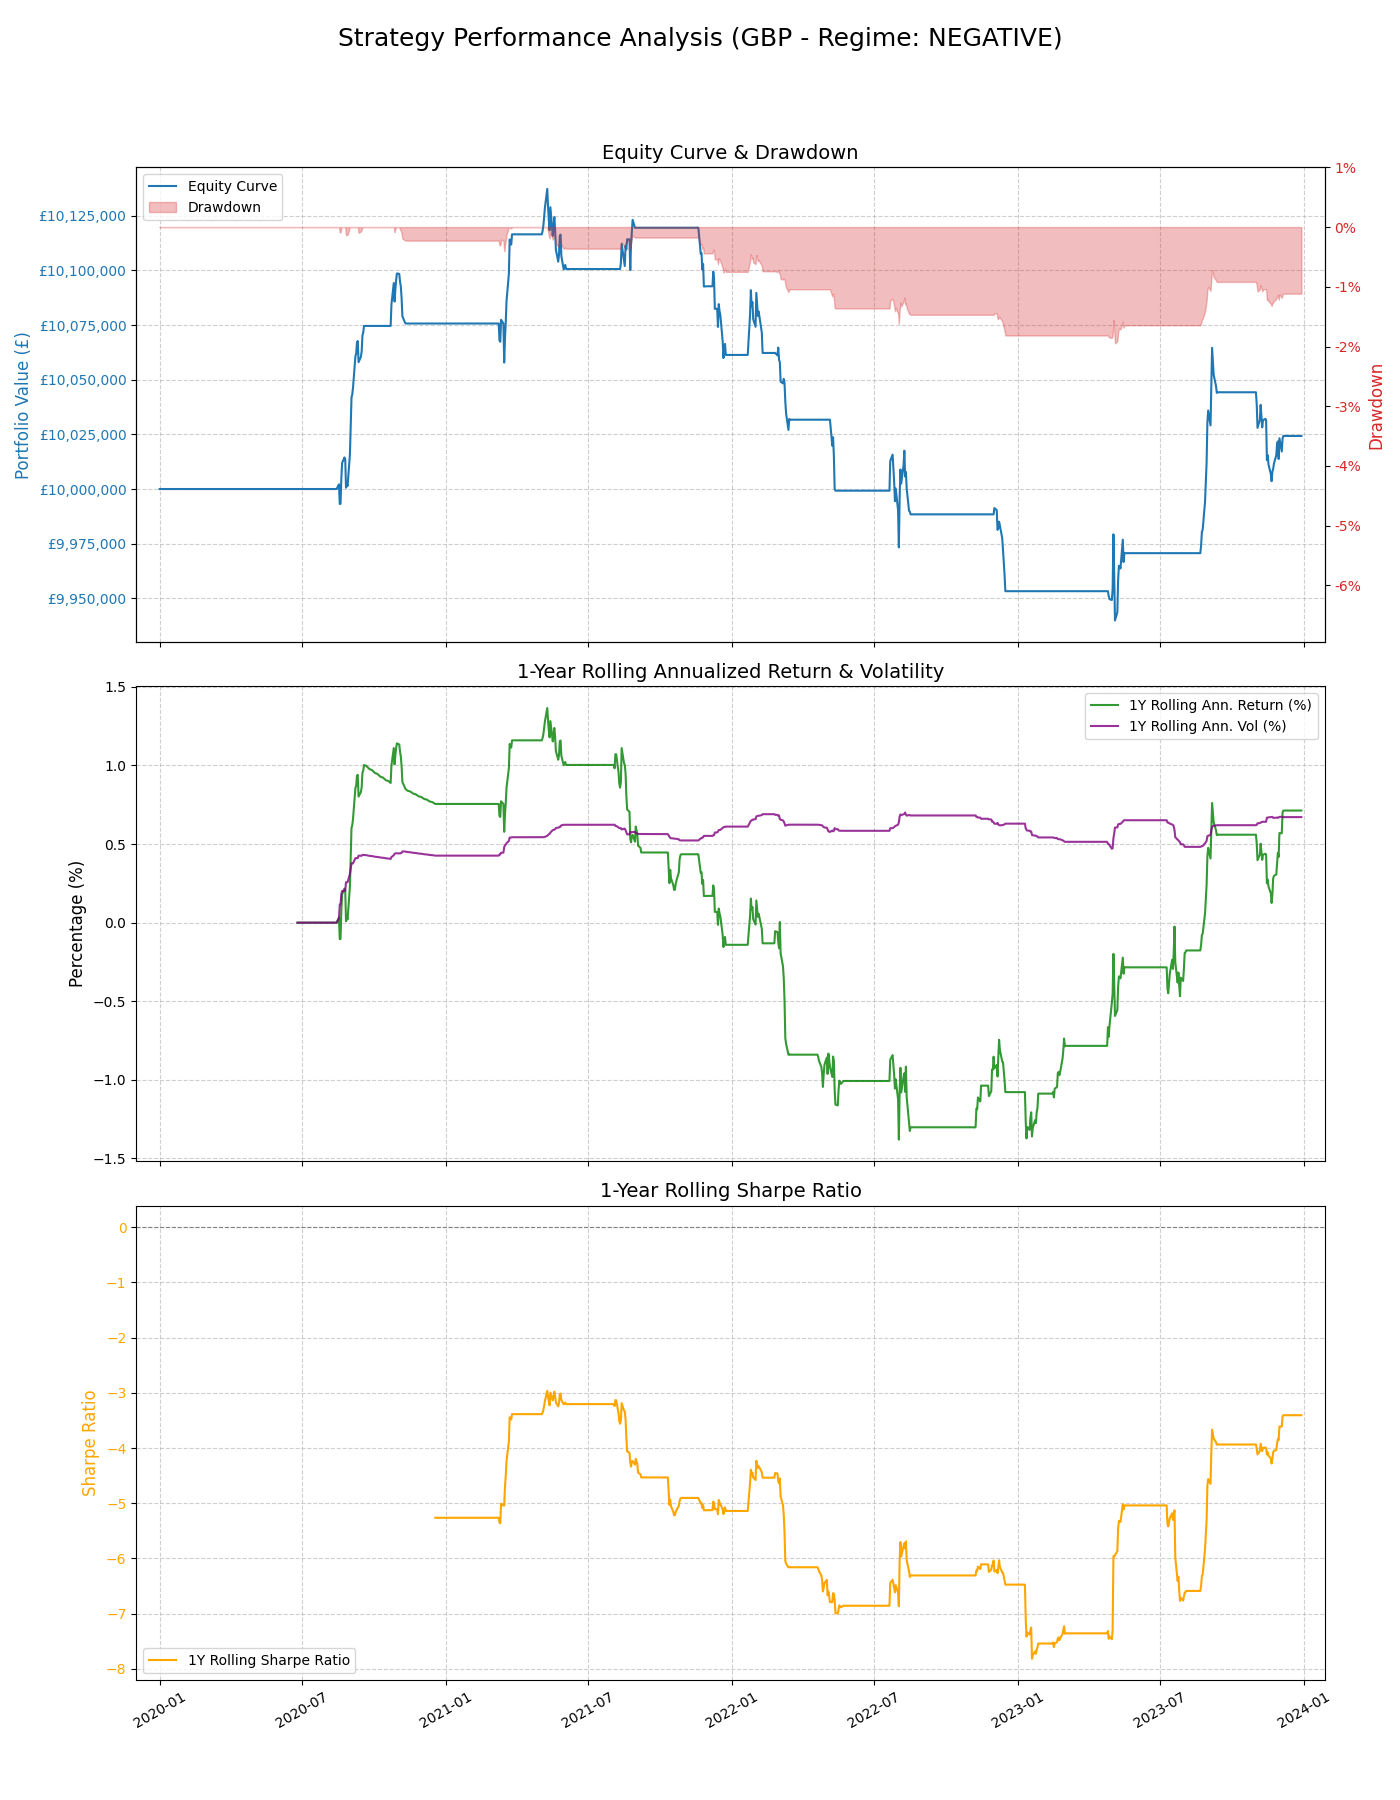


--- Negative Regime Factor Attribution ---


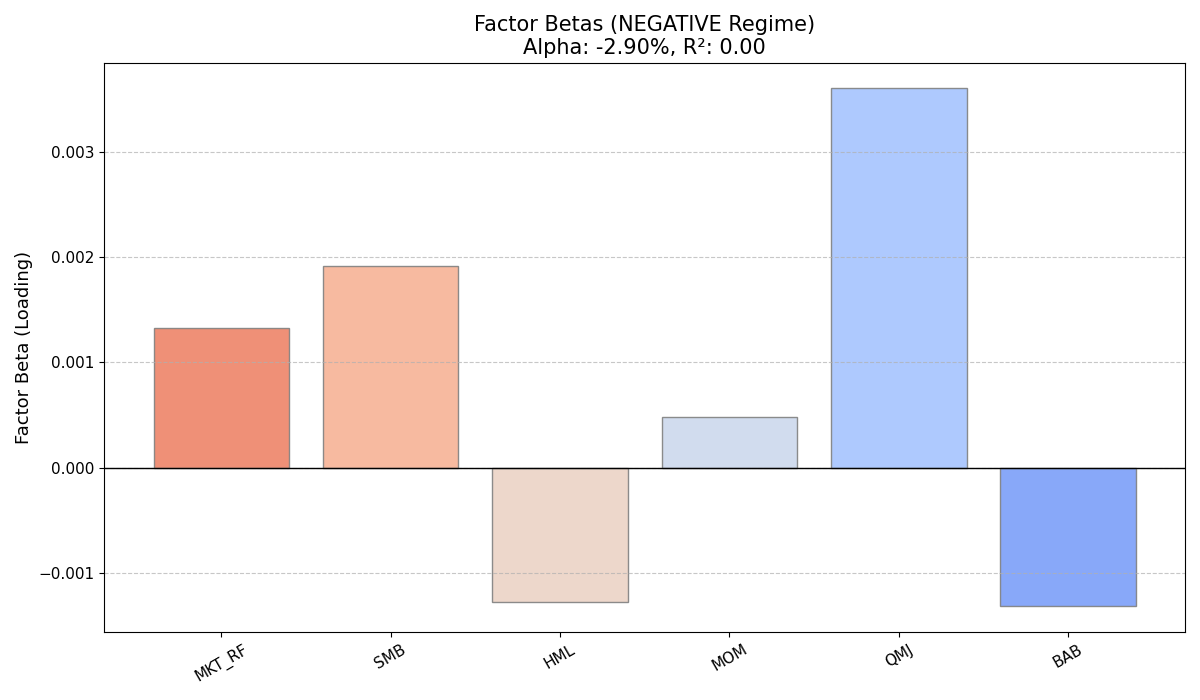

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import os

# --- Configuration (should match the cache_dir from your main script) ---
# You might need to recreate the config objects or just know the cache directory names

# Configuration for the POSITIVE regime run
positive_regime_cache_dir = 'simulated_data_cache_v2_2_3_positive'
# Configuration for the NEGATIVE regime run
negative_regime_cache_dir = 'simulated_data_cache_v2_2_3_negative'

# --- Filenames (should match how they are saved in PerformanceAnalyzer) ---
plot_filenames = {
    "Positive Regime Performance Summary": os.path.join(positive_regime_cache_dir, "performance_summary_plots_POSITIVE.png"),
    "Positive Regime Factor Attribution": os.path.join(positive_regime_cache_dir, "factor_attribution_POSITIVE.png"),
    "Negative Regime Performance Summary": os.path.join(negative_regime_cache_dir, "performance_summary_plots_NEGATIVE.png"),
    "Negative Regime Factor Attribution": os.path.join(negative_regime_cache_dir, "factor_attribution_NEGATIVE.png"),
}

# --- Function to display an image ---
def display_plot(filepath, title="Plot"):
    """
    Loads and displays a plot from a given filepath.
    """
    if os.path.exists(filepath):
        print(f"\n--- {title} ---")
        # Using IPython.display.Image for potentially better rendering in some notebook environments
        display(Image(filename=filepath))
        # Alternatively, using matplotlib:
        # img = mpimg.imread(filepath)
        # plt.figure(figsize=(15, 10)) # Adjust size as needed
        # plt.imshow(img)
        # plt.axis('off') # Hide axes for image display
        # plt.title(title, fontsize=16)
        # plt.show()
    else:
        print(f"Plot not found at: {filepath}")

# --- Display all the plots ---
for title, filepath in plot_filenames.items():
    display_plot(filepath, title)

# If you prefer to show them using matplotlib's plt.show() for more control (e.g., in a script outside a notebook)
# you can modify the display_plot function. For notebooks, IPython.display.Image is often cleaner.

# To ensure plots appear inline in Jupyter/Colab if using plt.show():
# You might need to run this magic command in a cell *before* plotting or displaying with plt.show()
# %matplotlib inline
